In [73]:
import pandas as pd
import numpy as np
from sympy import symbols, solve
from math import e
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [74]:
df_vol = pd.read_excel("DiscountFactorData.xlsx", sheet_name=0)
df_d = pd.read_excel("DiscountFactorData.xlsx", sheet_name=1)
df = pd.merge(df_vol, df_d, on="T", how="inner")
df["Yield"] = (1/df["D(T)"]) ** (1/(df["T"]*2)) - 1
for i in range(1,len(df)):
    df.at[i,"Forward"] = ((1+df.at[i,"Yield"]) ** (i+1))/((1+df.at[i-1,"Yield"]) ** i)
    df.at[i,"Forward"] -= 1
df.at[0,"Forward"] = df.at[0,"Yield"]
df[:5]

,T,Sigma,D(T),Yield,Forward
0,0.5,0.100,0.972476,0.028302,0.028302
1,1.0,0.120,0.944569,0.028924,0.029545
2,1.5,0.135,0.916324,0.029557,0.030825
3,2.0,0.150,0.887934,0.030160,0.031973
4,2.5,0.160,0.859741,0.030686,0.032793


In [145]:
# Pascal numbers will give us the probablity distribution of cash flows in a BDT Tree
def pascal_numbers(n):
    res = []
    res.append([1])
    for i in range(1,n):
        pascal = [1]
        for j in range(1,i):
            elem = res[i-1][j] + res[i-1][j-1]
            pascal.append(elem)
        pascal.append(1)
        res.append(pascal)
    return res

# We store all the r* (ru) for the BDT tree using sigma and m value
def bdt_rate_tree(sigma, m, dt, i, n, tree):
    if i > n:
        return
    r = tree[i-1]
    tree.append(r * (e ** (m[i-1] * dt + sigma[i-1] * (dt ** 0.5))))
    bdt_rate_tree(sigma, m, dt, i+1, n, tree)

# Creating the expected cash flows from the BDT generated rates
def bdt_cf_tree(rate_tree, disc_f, i, sigma, sqrt_dt, cf_tree):
    if i == len(rate_tree):
        return
    cf_nodes = []
    r = rate_tree[i]
    
    # CF(i) = CF(i-1) * (1 + r)
    prev_cf = disc_f
    if i > 0:
        prev_cf = cf_tree[i-1][0]
    cf_nodes.append(prev_cf * (1+r))

    # Generating all Cash Flows for i'th level 
    for j in range(1, i+1):
        
        # In BDT model the ratio of ru to rd = exp(2 * sigma * dw) for the tree to converge
        r = r / (e ** (2 * sigma[i-1] * sqrt_dt))  
        prev_cf = cf_tree[i-1][j-1]
        cf_nodes.append(prev_cf * (1+r))

    cf_tree.append(cf_nodes)
    
    # Recursively build the CF tree
    bdt_cf_tree(rate_tree, disc_f, i+1, sigma, sqrt_dt, cf_tree)
    
def weighted_sum(cf_tree, i, pdf):
    wt_sum = 0
    outcomes = np.sum(pdf[i])
    prob = 0
    for j in range(len(cf_tree[i])):
        wt_sum += (pdf[i][j]/outcomes) * cf_tree[i][j]
        prob += (pdf[i][j]/outcomes)
    return wt_sum

def calc_cf_exp(m, m_act, df, i, pdf):
    m_est = m_act.copy()
    m_est.append(m)
    rate_tree = [df.at[0, "Yield"]]
    bdt_rate_tree(df["Sigma"], m_est, 1, 1, i+1, rate_tree)
    #print(rate_tree)

    cf_tree = []
    bdt_cf_tree(rate_tree, df.at[i, "D(T)"], 0, df["Sigma"], 1, cf_tree)
    #print(cf_tree[i+1])

    #(expected cf[i] * discount factor[i]) : 1 :: m_est[i] : m_act[i]
    cf_exp = weighted_sum(cf_tree, i+1, pdf)
    return (cf_exp - 1)

def bootstrap(df):
    
    # To store calculated m values
    m_est = []   
    
    # pascal numbers at ith level give the probablity distribution of cash flows at ith level
    pdf = pascal_numbers(len(df)+1)

    # Find actual m by comparing estimates with an expected cash flow of 1
    for i in range(len(df)):
        m = fsolve(calc_cf_exp, np.random.rand(), args=(m_est, df, i, pdf))
        m_est.append(m[0])
    
    # Fill value of m and r* in dataframe
    df["m"] = m_est
    rate_tree = [df.at[0, "Yield"]]
    bdt_rate_tree(df["Sigma"], m_est, 1, 1, len(df)-1, rate_tree)
    df["r*"] = rate_tree

In [146]:
bootstrap(df)
df

D:\Applications\Anaconda\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


,T,Sigma,D(T),Yield,Forward,m,r*
0,0.5,0.100,0.972476,0.028302,0.028302,-32.559913,2.830248e-02
1,1.0,0.120,0.944569,0.028924,0.029545,0.650512,2.262890e-16
2,1.5,0.135,0.916324,0.029557,0.030825,0.623179,4.889819e-16
3,2.0,0.150,0.887934,0.030160,0.031973,0.904320,1.043676e-15
4,2.5,0.160,0.859741,0.030686,0.032793,31.986395,2.995375e-15
5,3.0,0.162,0.832044,0.031119,0.033288,-2.367151,2.738125e-01
6,3.5,0.164,0.805077,0.031459,0.033496,-0.182364,3.018341e-02
7,4.0,0.162,0.778904,0.031726,0.033602,-0.051293,2.963416e-02
8,4.5,0.160,0.753480,0.031950,0.033742,0.051487,3.310336e-02
9,5.0,0.157,0.728734,0.032151,0.033958,0.062404,4.089966e-02


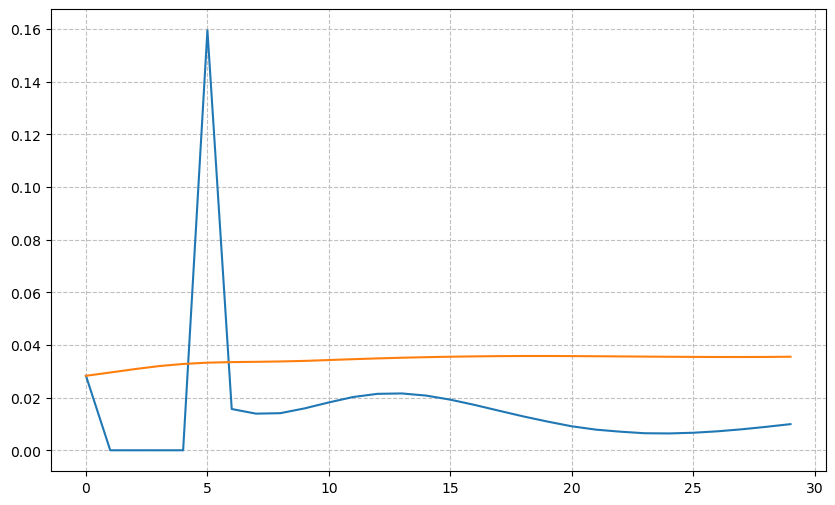

In [147]:
def expected_rate(r_tree, sigma, sqrt_dt, i, pdf):
    wt_sum = 0
    outcomes = np.sum(pdf[i])
    r = r_tree[i] #r*
    for j in range(i+1):
        wt_sum += (pdf[i][j]/outcomes) * r
        r = r / (e ** (2 * sigma[i] * sqrt_dt))  
    return wt_sum

# Pascal numbers applies for expected value of rates too
pdf = pascal_numbers(len(df))
r_exp = [expected_rate(df["r*"], df["Sigma"], 0.5 ** 0.5, i, pdf) for i in range(len(df))]
plt.figure(figsize=(10,6))
plt.grid(linestyle="--", color="silver")
plt.plot(r_exp)
plt.plot(df["Forward"])